In [1]:
%load_ext autoreload
%autoreload 2
from boxes import *
from learner import *
import math
import matplotlib.pyplot as plt
import os
import wandb
import pickle

import numpy as np

import matplotlib.patches as patches
import matplotlib.colors as mcolors


%matplotlib inline

In [2]:
# PATH = "../data/ontologies/anatomy/"

# with open(f'{PATH}human.pickle', 'rb') as handle:
#     human = pickle.load(handle)
    
# with open(f'{PATH}mouse.pickle', 'rb') as handle:
#     mouse = pickle.load(handle)

# with open(f'{PATH}entities.pickle', 'rb') as handle:
#     entities = pickle.load(handle)

In [3]:
# children_dict = {
#     1:[2],
#     2:[3, 4],
#     3:[6],
#     4:[5, 6],
#     6:[7, 8, 9],
#     10:[11, 12],
#     11:[13],
#     12:[14],
#     13:[15, 16],
#     14:[15, 16],
#     15:[17, 18, 19],
#     5:[5],
#     7:[7],
#     8:[8],
#     9:[9],
#     16:[16],
#     17:[17],
#     18:[18],
#     19:[19]
# }
children_dict = {
    0:[0, 0, 0],
    1:[2, 2, 2],
    2:[3, 4, 4],
    3:[6, 6, 6],
    4:[5, 6, 6],
    6:[7, 8, 9],
    10:[11, 12, 12],
    11:[13, 13, 13],
    12:[14, 14, 14],
    13:[15, 16, 16],
    14:[15, 16, 16],
    15:[17, 18, 19],
    5:[5, 5, 5],
    7:[7, 7, 7],
    8:[8, 8, 8],
    9:[9, 9, 9],
    16:[16, 16, 16],
    17:[17, 17, 17],
    18:[18, 18, 18],
    19:[19, 19, 19]
}

In [4]:
# parents_dict = {
#     7:[6],
#     8:[6],
#     9:[6],
#     5:[4],
#     6:[3, 4],
#     3:[2],
#     4:[2],
#     2:[1],
#     17:[15],
#     18:[15],
#     19:[15],
#     15:[13, 14],
#     16:[13, 14],
#     13:[11],
#     14:[12],
#     11:[10],
#     12:[10],
#     1:[1],
#     10:[10]
# }
parents_dict = {
    0:[0, 0, 0],
    7:[6, 6, 6],
    8:[6, 6, 6],
    9:[6, 6, 6],
    5:[4, 4, 4],
    6:[3, 4, 4],
    3:[2, 2, 2],
    4:[2, 2, 2],
    2:[1, 1, 1],
    17:[15, 15, 15],
    18:[15, 15, 15],
    19:[15, 15, 15],
    15:[13, 14, 14],
    16:[13, 14, 14],
    13:[11, 11, 11],
    14:[12, 12, 12],
    11:[10, 10, 10],
    12:[10, 10, 10],
    1:[1, 1, 1],
    10:[10, 10, 10]
}

In [5]:
parents_dict

{0: [0, 0, 0],
 7: [6, 6, 6],
 8: [6, 6, 6],
 9: [6, 6, 6],
 5: [4, 4, 4],
 6: [3, 4, 4],
 3: [2, 2, 2],
 4: [2, 2, 2],
 2: [1, 1, 1],
 17: [15, 15, 15],
 18: [15, 15, 15],
 19: [15, 15, 15],
 15: [13, 14, 14],
 16: [13, 14, 14],
 13: [11, 11, 11],
 14: [12, 12, 12],
 11: [10, 10, 10],
 12: [10, 10, 10],
 1: [1, 1, 1],
 10: [10, 10, 10]}

In [6]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu
    torch.cuda.manual_seed_all(seed)  # gpu
    
set_seed(54321)

torch.set_printoptions(precision=16)

split_num = 9
weight_alignment_loss = 1
Threshold = 0.5

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
use_cuda

False

In [8]:
PATH = 'data/ontologies/anatomy/debug/'

# aligment training split
ats = ""

# Transitive closure
Transitive_Closure = False

if Transitive_Closure:
    tc = "tc_"
else:
    tc = ""

# Data in unary.tsv are probabilites separated by newlines. The probability on line n is P(n), where n is the id assigned to the nth element.
unary_prob = [1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
#unary_prob = [1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 1/3]
unary_prob = torch.tensor(unary_prob).float().to(device)
num_boxes = unary_prob.shape[0]

# We're going to use random negative sampling during training, so no need to include negatives in our training data itself
train = Probs.load_from_julia(PATH, f'tr_pos-Copy1.tsv', f'tr_neg-Copy1.tsv', ratio_neg = 7).to(device)

# The dev set will have a fixed set of negatives, however.
dev = Probs.load_from_julia(PATH, f'dev_align_pos-Copy1.tsv', f'dev_align_neg-Copy1.tsv', ratio_neg = 4).to(device)

# This set is used just for evaluation purposes after training
tr_align = Probs.load_from_julia(PATH, f'tr_align_pos-Copy1.tsv', f'tr_align_neg-Copy1.tsv', ratio_neg = 0).to(device)


In [9]:
mouse_eval = Probs.load_from_julia(PATH, 'human_dev_pos-Copy1.tsv', 'human_dev_neg-Copy1.tsv', ratio_neg = 0).to(device)
human_eval = Probs.load_from_julia(PATH, 'mouse_dev_pos-Copy1.tsv', 'mouse_dev_neg-Copy1.tsv', ratio_neg = 0).to(device)


In [10]:
# def test_multi_intersection(A: Tensor) -> Tensor:
#     """
#     :param A: Tensor(..., zZ, dim)
#     :return: Tensor(..., zZ, dim)
#     """
#     print("A:", A.shape)
#     z = torch.max(A[...,0,:], dim=2).values
    
#     print("z:", z.shape)
    
#     Z = torch.min(A[...,0,:], dim=2).values
    
#     print("result:", torch.stack((z, Z), dim=-2).shape)
#     return torch.stack((z, Z), dim=-2)

# test_multi_intersection(torch.randn(1, 28, 3, 2, 2))

In [11]:
import torch
from torch import Tensor # for type annotations
import torch.nn.functional as F
from typing import *

def multi_intersection(A: Tensor) -> Tensor:
    """
    :param A: Tensor(..., zZ, dim)
    :return: Tensor(..., zZ, dim)
    """

    z = torch.max(A[...,0,:], dim=2).values
    Z = torch.min(A[...,1,:], dim=2).values
    
    return torch.stack((z, Z), dim=-2)

def multi_join(A: Tensor) -> Tensor:
    """
    :param A: Tensor(model, pair, zZ, dim)
    :return: Tensor(model, pair, zZ, dim)
    """
    z = torch.min(A[...,0,:], dim=2).values
    Z = torch.max(A[...,1,:], dim=2).values
    return torch.stack((z, Z), dim=-2)


def gumbel_intersection(A: Tensor, B: Tensor, gumbel_beta: float=1.)-> Tensor:
    Az = A[...,0,:]
    AZ = A[...,1,:]
    Bz = B[...,0,:]
    BZ = B[...,1,:]
    
    gumbel_beta = 0.1
    z = gumbel_beta * torch.logsumexp(torch.stack((Az / gumbel_beta, Bz / gumbel_beta)), 0)
    z = torch.max(z, torch.max(Az, Bz))
    Z = - gumbel_beta * torch.logsumexp(torch.stack((-AZ / gumbel_beta, -BZ / gumbel_beta)), 0)
    Z = torch.min(Z, torch.min(AZ, BZ))
    return torch.stack((z, Z), dim=-2)


def log_soft_volume_adjusted(
                     boxes: Tensor,
                     temp: float = 1.,
                     gumbel_beta: float = 1.,
                     scale: Union[float, Tensor] = 1.) -> Tensor:
    
    euler_gamma = 0.57721566490153286060
    gumbel_beta = 0.1
    
    z = boxes[:,:,0]
    Z = boxes[:,:,1]
    eps = torch.finfo(z.dtype).tiny  # type: ignore
    

    
    if isinstance(scale, float):
        s = torch.tensor(scale)
    else:
        s = scale

    return (torch.sum(
        torch.log(F.softplus(Z - z - 2*euler_gamma*gumbel_beta, beta=temp).clamp_min(eps)),
        dim=-1) + torch.log(s)
    )




def intersection(A: Tensor, B: Tensor) -> Tensor:
    """
    :param A: Tensor(..., zZ, dim)
    :param B: Tensor(..., zZ, dim)
    :return: Tensor(..., zZ, dim), box embeddings for A intersect B
    """
    z = torch.max(A[...,0,:], B[...,0,:])
    Z = torch.min(A[...,1,:], B[...,1,:])
    
#     z = gumbel_beta * torch.logsumexp(torch.stack((t1.z / gumbel_beta, t2.z / gumbel_beta)), 0)
#     z = torch.max(z, torch.max(t1.z, t2.z))
#     Z = - gumbel_beta * torch.logsumexp(torch.stack((-t1.Z / gumbel_beta, -t2.Z / gumbel_beta)), 0)
#     Z = torch.min(Z, torch.min(t1.Z, t2.Z))
    return torch.stack((z, Z), dim=-2)

def neg_edge_adjustment(A: Tensor) -> Tensor:
    """
    :param A: Tensor(..., zZ, dim)
    
    Replace "negative" edges with their mean.
    
    (TODO: optimize this)
    """
    center_of_meet = torch.mean(A, dim=-2)
    neg_edges_mask = ((A[...,1,:] - A[...,0,:]) >= 0)
    neg_edges_mask_stack = torch.stack((neg_edges_mask, neg_edges_mask), dim=-2)
    center_of_meet_stack = torch.stack((center_of_meet, center_of_meet), dim=-2)
    return torch.where(neg_edges_mask_stack, A, center_of_meet_stack)

def join(A: Tensor, B: Tensor) -> Tensor:
    """
    :param A: Tensor(model, pair, zZ, dim)
    :param B: Tensor(model, pair, zZ, dim)
    :return: Tensor(model, pair, zZ, dim), box embeddings for the smallest box which contains A and B
    """
    z = torch.min(A[:,:,0], B[:,:,0])
    Z = torch.max(A[:,:,1], B[:,:,1])
    return torch.stack((z, Z), dim=2)


def clamp_volume(boxes: Tensor) -> Tensor:
    """
    :param boxes: Tensor(... zZ, dim)
    :return: Tensor(...) of volumes
    """
    return torch.prod((boxes[...,1,:] - boxes[...,0,:]).clamp_min(0), dim=-1)


def soft_volume(boxes: Tensor) -> Tensor:
    """
    :param sidelengths: Tensor(model, box, dim)
    :return: Tensor(model, box) of volumes
    """
#     print("you are in soft_volume now!!!")
#     print("Z:",boxes[:,0,1])
#     print("z:",boxes[:,0,0])
#     print("boxes[:,0,1] - boxes[:,0,0]:", boxes[:,0,1] - boxes[:,0,0])
#     print("after softplus:", F.softplus(boxes[:,0,1] - boxes[:,0,0]))
    return torch.prod(F.softplus(boxes[:,:,1] - boxes[:,:,0]), dim=-1)


def log_clamp_volume(boxes: Tensor, eps:float = torch.finfo(torch.float32).tiny) -> Tensor:
    """
    :param boxes: Tensor(model, box, zZ, dim)
    :return: Tensor(model, box) of volumes
    """
    return torch.sum(torch.log((boxes[:,:,1] - boxes[:,:,0]).clamp_min(0) + eps), dim=-1)


def log_soft_volume(boxes: Tensor, eps:float = torch.finfo(torch.float32).tiny) -> Tensor:
    """
    :param sidelengths: Tensor(model, box, dim)
    :return: Tensor(model, box) of volumes
    """
    return torch.sum(torch.log(F.softplus(boxes[:,:,1] - boxes[:,:,0]) + eps), dim=-1)


def smallest_containing_box(boxes: Tensor) -> Tensor:
    """
    Returns the smallest box which contains all boxes in `boxes`.
    
    :param boxes: Box embedding of shape (model, box, zZ, dim)
    :return: Tensor of shape (model, 1, zZ, dim)
    """
    z = boxes[:,:,0]
    Z = boxes[:,:,1]
    min_z, _ = torch.min(z, dim=1, keepdim=True)
    max_Z, _ = torch.max(Z, dim=1, keepdim=True)
    return torch.stack((min_z, max_Z), dim=2)

def smallest_containing_box_outside_unit_cube(boxes: Tensor) -> Tensor:
    """
    Returns the smallest box which contains all boxes in `boxes` and the unit cube.

    :param boxes: Box embedding of shape (model, box, zZ, dim)
    :return: Tensor of shape (model, 1, zZ, dim)
    """
    z = boxes[:,:,0]
    Z = boxes[:,:,1]
    min_z, _ = torch.min(z, dim=1, keepdim=True)
    max_Z, _ = torch.max(Z, dim=1, keepdim=True)
    min_z = min_z.clamp_max(0)
    max_Z = max_Z.clamp_min(1)
    return torch.stack((min_z, max_Z), dim=2)


def detect_small_boxes(boxes: Tensor, vol_func: Callable = clamp_volume, min_vol: float = 1e-20) -> Tensor:
    """
    Returns the indices of boxes with volume smaller than eps.

    :param boxes: box parametrization as Tensor(model, box, z/Z, dim)
    :param vol_func: function taking in side lengths and returning volumes
    :param min_vol: minimum volume of boxes
    :return: masked tensor which selects boxes whose side lengths are less than min_vol
    """
    return vol_func(boxes) < min_vol


def replace_Z_by_cube(boxes: Tensor, indices: Tensor, cube_vol: float = 1e-20) -> Tensor:
    """
    Returns a new Z parameter for boxes for which those boxes[indices] are now replaced by cubes of size cube_vol

    :param boxes: box parametrization as Tensor(model, box, z/Z, dim)
    :param indices: box indices to replace by a cube
    :param cube_vol: volume of cube
    :return: tensor representing the Z parameter
    """
    return boxes[:, :, 0][indices] + cube_vol ** (1 / boxes.shape[-1])



def replace_Z_by_cube_(boxes: Tensor, indices: Tensor, cube_vol: float = 1e-20) -> Tensor:
    """
    Replaces the boxes indexed by `indices` by a cube of volume `min_vol` with the same z coordinate

    :param boxes: box parametrization as Tensor(model, box, z/Z, dim)
    :param indices: box indices to replace by a cube
    :param cube_vol: volume of cube
    :return: tensor representing the box parametrization with those boxes
    """
    boxes[:, :, 1][indices] = replace_Z_by_cube(boxes, indices, cube_vol)


def disjoint_boxes_mask(A: Tensor, B: Tensor) -> Tensor:
    """
    Returns a mask for when A and B are disjoint.
    Note: This is symmetric with respect to the arguments.
    """
    return ((B[:,:,1] <= A[:,:,0]) | (B[:,:,0] >= A[:,:,1])).any(dim=-1)


def overlapping_boxes_mask(A: Tensor, B: Tensor) -> Tensor:
    return disjoint_boxes_mask(A, B) ^ 1


def containing_boxes_mask(A: Tensor, B: Tensor) -> Tensor:
    """
    Returns a mask for when B contains A.
    Note: This is *not* symmetric with respect to it's arguments!
    """
    return ((B[:,:,1] >= A[:,:,1]) & (B[:,:,0] <= A[:,:,0])).all(dim=-1)


def needing_pull_mask(A: Tensor, B: Tensor, target_prob_B_given_A: Tensor) -> Tensor:
    return (target_prob_B_given_A != 0) & disjoint_boxes_mask(A, B)


def needing_push_mask(A: Tensor, B: Tensor, target_prob_B_given_A: Tensor) -> Tensor:
    return (target_prob_B_given_A != 1) & containing_boxes_mask(A, B)


In [12]:
import torch
from torch import Tensor
import scipy.stats as spstats # For Spearman r
from sklearn.metrics import roc_curve, precision_recall_curve  # for roc_curve


def metric_hard_accuracy(model, data_in, data_out):
    hard_pred = model(data_in, is_align=torch.tensor(0))["P(A|B)_evaluate"] > Threshold
#     print("data_in:", data_in)
#     print("hard_pred:", hard_pred)
    return (data_out == hard_pred.float()).float().mean()


def metric_hard_f1(model, data_in, data_out):
    hard_pred = model(data_in, is_align=torch.tensor(0))["P(A|B)_evaluate"] > Threshold
    true_pos = data_out[hard_pred==1].sum()
    total_pred_pos = (hard_pred==1).sum().float()
    total_actual_pos = data_out.sum().float()
    precision = true_pos / total_pred_pos
    recall = true_pos / total_actual_pos
    return 2 * (precision*recall) / (precision + recall)

def metric_hard_accuracy_align(model, data_in, data_out, threshold:float):
    A_given_B = data_in[::2]
    B_given_A = data_in[1::2,:]
    data_out = data_out[::2]
    

    align_probs = torch.stack((model(A_given_B, is_align=torch.tensor(1))["P(A|B)_evaluate"], model(B_given_A, is_align=torch.tensor(1))["P(A|B)_evaluate"]), dim=1)
    p = torch.min(align_probs, dim=1).values
    hard_pred = p > threshold
    
    print("A_given_B:", A_given_B, model(A_given_B, is_align=torch.tensor(1))["P(A|B)_evaluate"])
    print("B_given_A:", B_given_A, model(B_given_A, is_align=torch.tensor(1))["P(A|B)_evaluate"])
#     print("data_out:", data_out)
    
#     print("metric_hard_accuracy_align:", p, threshold, (data_out == hard_pred).float().mean())

    return (data_out == hard_pred).float().mean()

def metric_hard_f1_align(model, data_in, data_out, threshold:float):
    A_given_B = data_in[::2]
    B_given_A = data_in[1::2,:]
    data_out = data_out[::2]

    align_probs = torch.stack((model(A_given_B, is_align=torch.tensor(1))["P(A|B)_evaluate"], model(B_given_A, is_align=torch.tensor(1))["P(A|B)_evaluate"]), dim=1)
    p = torch.min(align_probs, dim=1).values
    hard_pred = p > threshold

    true_pos = data_out[hard_pred==1].sum()
    total_pred_pos = (hard_pred==1).sum().float()
    total_actual_pos = data_out.sum().float()

    precision = true_pos / total_pred_pos
    recall = true_pos / total_actual_pos

    return 2 * (precision*recall) / (precision + recall)

def metric_hard_accuracy_align_mean(model, data_in, data_out, threshold):
    A_given_B = data_in[::2]
    B_given_A = data_in[1::2,:]
    data_out = data_out[::2]

    align_probs = torch.stack((model(A_given_B, is_align=torch.tensor(1))["P(A|B)_evaluate"], model(B_given_A, is_align=torch.tensor(1))["P(A|B)_evaluate"]), dim=1)
    p = torch.mean(align_probs, dim=1)
    hard_pred = p > threshold

    return (data_out == hard_pred).float().mean()

def metric_hard_f1_align_mean(model, data_in, data_out, threshold):
    A_given_B = data_in[::2]
    B_given_A = data_in[1::2,:]
    data_out = data_out[::2]

    align_probs = torch.stack((model(A_given_B, is_align=torch.tensor(1))["P(A|B)_evaluate"], model(B_given_A, is_align=torch.tensor(1))["P(A|B)_evaluate"]), dim=1)
    p = torch.mean(align_probs, dim=1)
    hard_pred = p > threshold

    true_pos = data_out[hard_pred==1].sum()
    total_pred_pos = (hard_pred==1).sum().float()
    total_actual_pos = data_out.sum().float()

    precision = true_pos / total_pred_pos
    recall = true_pos / total_actual_pos

    return 2 * (precision*recall) / (precision + recall)


In [13]:
import torch
from torch.utils.data import Dataset
from typing import *
from dataclasses import dataclass, field
import wandb

try:
    from IPython import get_ipython
    if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
        raise ImportError("console")
except:
    pass
else:
    import ipywidgets as widgets
    from IPython.core.display import HTML, display

if TYPE_CHECKING:
    from learner import Learner, Recorder


class Callback:
    def learner_post_init(self, learner: Learner):
        pass

    def train_begin(self, learner: Learner):
        pass

    def epoch_begin(self, learner: Learner):
        pass

    def batch_begin(self, learner: Learner):
        pass

    def backward_end(self, learner: Learner):
        pass

    def batch_end(self, learner: Learner):
        pass

    def epoch_end(self, learner: Learner):
        pass

    def train_end(self, learner: Learner):
        pass

    def eval_align(self, learner: Learner, threshold:float):
        pass

    def metric_plots(self, l: Learner):
        pass

    def eval_end(self, l: Learner):
        pass

    def bias_metric(self, l: Learner):
        pass

class CallbackCollection:

    def __init__(self, *callbacks: Callback):
        self._callbacks = callbacks

    def __call__(self, action: str, *args, **kwargs):
        for c in self._callbacks:
            getattr(c, action)(*args, **kwargs)

    def __getattr__(self, action: str):
        return lambda *args, **kwargs: self.__call__(action, *args, **kwargs)


@dataclass
class GradientClipping(Callback):
    min: float = None
    max: float = None

    def backward_end(self, learner: Learner):
        for param in learner.model.parameters():
            if param.grad is not None:
#                 print("grad:", param.grad)
                param.grad = param.grad.clamp(self.min, self.max)


@dataclass
class LossCallback(Callback):
    recorder: Recorder
    ds: Dataset
    weighted: bool = True

    @torch.no_grad()
    def train_begin(self, learner: Learner):
        self.epoch_end(learner)

    @torch.no_grad()
    def epoch_end(self, l: Learner):
        data_in, data_out = self.ds[:]
        if l.categories:
            split_in, split_out = l.split_data(data_in, data_out, split=2737)
            
            model_pred = []
            count = 0
            for item in split_in:
                if len(item)>0:
                    if count<2:
                        model_pred.append(l.model(item, is_align=torch.tensor(0)))
                    else:
                        model_pred.append(l.model(item, is_align=torch.tensor(1)))
                else:
                    model_pred.append({'P(A|B)':l.TensorNaN(device=data_in.device)})
                count+=1

            #model_pred = [l.model(item) if len(item)>0 else {'P(A|B)':l.TensorNaN(device=data_in.device)} for item in split_in]
            l.loss_fn(model_pred, split_out, l, self.recorder, weighted=self.weighted, categories=True)  
        else:
            output = l.model(data_in, is_align=torch.tensor(0))
            l.loss_fn(output, data_out, l, self.recorder, weighted=self.weighted) # this logs the data to the recorder


@dataclass
class MetricCallback(Callback):
    recorder: Recorder
    ds: Dataset
    data_categories: str
    metric: Callable
    use_wandb: bool = False
    name: Union[str, None] = None

    def __post_init__(self):
        if self.name is None:
            self.name = self.metric.__name__
        self.name = self.recorder.get_unique_name(self.name)

    @torch.no_grad()
    def train_begin(self, learner: Learner):
        self.epoch_end(learner)

    @torch.no_grad()
    def epoch_end(self, l: Learner):
        data_in, data_out = self.ds[:]
        metric_val = self.metric(l.model, data_in, data_out)
        self.recorder.update_({self.name: metric_val}, l.progress.current_epoch_iter)
        
        print("evaluation_" + self.data_categories + "_" + self.name, str(metric_val))
        
        if self.use_wandb:
            metric_name = "evaluation_" + self.data_categories + "_" + self.name
            wandb.log({metric_name: metric_val})

@dataclass
class EvalAlignment(Callback):
    recorder: Recorder
    ds: Dataset
    data_categories: str
    metric: callable
    use_wandb: bool = False
    name: Union[str, None] = None
        

    def __post_init__(self):
        if self.name is None:
            self.name = self.metric.__name__
        self.name = self.recorder.get_unique_name(self.name)

    @torch.no_grad()
    def eval_align(self, l: Learner, threshold: float):
        data_in, data_out = self.ds[:]
        metric_val = self.metric(l.model, data_in, data_out, threshold)
        self.recorder.update_({self.name: metric_val}, threshold)
        
        print("align_evaluation_" + self.data_categories + "_" + str(threshold) + "_" + self.name, str(metric_val))
        
        if self.use_wandb:
            metric_name = "align_evaluation_" + self.data_categories + "_" + str(threshold) + "_" + self.name
            wandb.log({metric_name: metric_val})


In [14]:
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Module, Parameter
import torch.nn.functional as F


################################################
# Box Parametrization Layers
################################################
default_init_min_vol = torch.finfo(torch.float32).tiny

def initialize_boxes_in_unit_cube(shape_prefix: Tuple[int], dims:int, init_min_vol: float = default_init_min_vol,
    method = "gibbs", gibbs_iter: int = 2000, **kwargs):
    """
    Creates the Parameters used for the representation of boxes.
    Initializes boxes with a uniformly random distribution of coordinates, ensuring that each box
    contains a cube of volume larger than init_min_vol.

    :param shape_prefix: Tuple which prefixes the parameters, eg. (num_boxes, num_models) will lead to
        a Tensor of shape (num_boxes, num_models, 2, dims)
    :param dims: Dimension of boxes
    :param init_min_vol: Minimum volume for boxes which are created
    :param kwargs: Unused for now, but include this for future possible parameters.
    """
    if method == "gibbs":
        sides = torch.ones(*shape_prefix, dims)
        log_min_vol = torch.log(torch.tensor(init_min_vol))
        for i in range(gibbs_iter):
            idx = torch.randint(0, dims, shape_prefix)[...,None]
            sides.scatter_(-1, idx, 1)
            complement = torch.log(sides).sum(dim=-1)
            min = torch.exp(log_min_vol - complement)[..., None]
            new_lengths = min + torch.rand(idx.shape) * (1 - min)
            sides.scatter_(-1, idx, new_lengths)

        z = torch.rand(*shape_prefix, dims) * (1-sides)
        Z = z + sides

    else:
        rand_param = lambda min, max: min + torch.rand(*shape_prefix, dims) * (max - min)
        if init_min_vol == 0:
            per_dim_min = 0
        elif init_min_vol > 0:
            per_dim_min = torch.tensor(init_min_vol).pow(1/dims)
        else:
            raise ValueError(f"init_min_vol={init_min_vol} is an invalid option.")

        z = rand_param(0, 1-per_dim_min)
        Z = rand_param(z+per_dim_min, 1)

    return torch.stack((z,Z), dim=-2)


class BoxParam(Module):
    """
    An example class for creating a box parametrization.
    Don't inherit from this, it is just an example which contains the methods for a class to be used as a BoxParam
    layer. Refer to the docstring of the functions when implementing your own BoxParam.

    Note: to avoid naming conflicts with min/max functions, we refer to the min coordinate for a box as `z`, and the
    max coordinate as `Z`.
    """

    def __init__(self, num_models:int, num_boxes:int, dim:int, **kwargs):
        """
        Creates the Parameters used for the representation of boxes.

        :param num_models: Number of models
        :param num_boxes: Number of boxes
        :param dim: Dimension
        :param kwargs: Unused for now, but include this for future possible parameters.
        """
        # Remember to call:
        super().__init__()
        raise NotImplemented


    def forward(self, box_indices = slice(None, None, None), **kwargs) -> Tensor:
        """
        Returns a Tensor representing the boxes specified by `box_indices` in the form they should be used for training.

        :param box_indices: Slice, List, or Tensor of the box indices
        :param kwargs: Unused for now, but include this for future possible parameters.
        :return: Tensor of shape (model, id, zZ, dim).
        """
        raise NotImplemented


class Boxes(Module):
    """
    Parametrize boxes using the min coordinate and max coordinate,
    initialized to be in the unit hypercube.

    self.boxes[model, box, min/max, dim] \in [0,1]

    In this parametrization, the min and max coordinates are explicitly stored
    in separate dimensions (as shown above), which means that care must be
    taken to preserve max > min while training. (See MinBoxSize Callback.)
    """

    def __init__(self, num_models: int, num_boxes: int, dims: int,
                 init_min_vol: float = default_init_min_vol, method = "gibbs", gibbs_iter: int = 2000, **kwargs):
        super().__init__()
        self.boxes = Parameter(initialize_boxes_in_unit_cube((num_models, num_boxes), dims, init_min_vol, method, gibbs_iter, **kwargs))

    def forward(self, box_indices = slice(None, None, None), **kwargs) -> Tensor:
        """
        Returns a Tensor representing the box embeddings specified by box_indices.

        :param box_indices: Slice, List, or Tensor of the box indices
        :param kwargs: Unused for now, but include this for future possible parameters.
        :return: NamedTensor of shape (model, id, zZ, dim).
        """
        return self.boxes[:, box_indices]



class MinMaxSigmoidBoxes(Module):
    """
    Parametrize boxes using sigmoid to make them always valid and contained within the unit cube.

    self.boxes[model, box, 2, dim] in Reals


    In this parametrization, we first convert to the unit cube:

    unit_cube_boxes = torch.sigmoid(self.boxes)  # shape: (model, box, 2, dim)

    We now select the z/Z coordinates by taking the min/max over axis 2, i.e.

    z, _ = torch.min(unit_cube_boxes, dim=2)
    Z, _ = torch.max(unit_cube_boxes, dim=2)
    """

    def __init__(self, num_models: int, num_boxes: int, dim: int, init_min_vol: float = default_init_min_vol,  **kwargs):
        super().__init__()
        unit_boxes = Boxes(num_models, num_boxes, dim, init_min_vol, **kwargs)
        self._from_UnitBoxes(unit_boxes)
        del unit_boxes


    def _from_UnitBoxes(self, unit_boxes:Boxes):
        boxes = unit_boxes().detach().clone()
        self.boxes = Parameter(torch.log(boxes / (1-boxes)))


    def forward(self, box_indices = slice(None, None, None), **kwargs) -> Tensor:
        """
        Returns a Tensor representing the box embeddings specified by box_indices.

        :param box_indices: A NamedTensor of the box indices
        :param kwargs: Unused for now, but include this for future possible parameters.
        :return: Tensor of shape (model, id, zZ, dim).
        """
        unit_cube_boxes = torch.sigmoid(self.boxes)
        z, _ = torch.min(unit_cube_boxes, dim=2)
        Z, _ = torch.max(unit_cube_boxes, dim=2)
        return torch.stack((z,Z), dim=2)
    
class AlignmentBoxes(Module):
    """
    Parametrize boxes using sigmoid to make them always valid and contained within the unit cube.

    self.boxes[model, box, 2, dim] in Reals


    In this parametrization, we first convert to the unit cube:

    unit_cube_boxes = torch.sigmoid(self.boxes)  # shape: (model, box, 2, dim)

    We now select the z/Z coordinates by taking the min/max over axis 2, i.e.

    z, _ = torch.min(unit_cube_boxes, dim=2)
    Z, _ = torch.max(unit_cube_boxes, dim=2)
    """

    def __init__(self, num_models: int, num_boxes: int, dim: int, init_min_vol: float = default_init_min_vol,  **kwargs):
        super().__init__()
        unit_boxes = Boxes(num_models, num_boxes, dim, init_min_vol, **kwargs)
        self._from_UnitBoxes(unit_boxes)
#         self.fc1 = nn.Linear(dim, 64)
#         self.fc2 = nn.Linear(64, dim)
        #self.fc = nn.Linear(dim, dim)
        del unit_boxes


    def _from_UnitBoxes(self, unit_boxes:Boxes):
        boxes = unit_boxes().detach().clone()
        self.boxes = Parameter(torch.log(boxes / (1-boxes)))


    def forward(self, box_indices = slice(None, None, None), is_align=torch.tensor(0), **kwargs) -> Tensor:
        """
        Returns a Tensor representing the box embeddings specified by box_indices.

        :param box_indices: A NamedTensor of the box indices
        :param kwargs: Unused for now, but include this for future possible parameters.
        :return: Tensor of shape (model, id, zZ, dim).
        """
        unit_cube_boxes = torch.sigmoid(self.boxes)
        z, _ = torch.min(unit_cube_boxes, dim=2)
        Z, _ = torch.max(unit_cube_boxes, dim=2)

#         if is_align.tolist() == 1:
# #             print("z before1:", z[0])
# #             print("w:", self.fc.weight)
# #             z = torch.nn.functional.relu(self.fc1(z))
# #             z = self.fc2(z)
# #             Z = torch.nn.functional.relu(self.fc1(Z))
# #             Z = self.fc2(Z)
#             z = self.fc1(z)
#             Z = self.fc1(Z)
#         else:
#             z = self.fc2(z)
#             Z = self.fc2(Z)

#         if is_align.tolist() == 1:
#             #print("before z", z)
#             #print("before Z", Z)
#             z = torch.nn.functional.relu(self.fc1(z))
#             z = self.fc2(z)
#             Z = torch.nn.functional.relu(self.fc1(Z))
#             Z = self.fc2(Z)
            #print("after z", z)
            #print("after Z", Z)
            
#         if is_align.tolist() == 1:    
#             z = self.fc(z)
#             Z = self.fc(Z)

        #print("z Z", torch.stack((z,Z), dim=2))
        return torch.stack((z,Z), dim=2)


###############################################
# Downstream Model
###############################################

class WeightedSum(Module):
    def __init__(self, num_models: int) -> None:
        super().__init__()
        self.weights = Parameter(torch.rand(num_models))

    def forward(self, box_vols: Tensor) -> Tensor:
        return (F.softmax(self.weights, dim=0).unsqueeze(0) @ box_vols).squeeze()


class LogWeightedSum(Module):
    def __init__(self, num_models: int) -> None:
        super().__init__()
        self.weights = Parameter(torch.rand(num_models))

    def forward(self, log_box_vols: Tensor) -> Tensor:
        return (torch.logsumexp(self.weights + log_box_vols, 0) - torch.logsumexp(self.weights, 0))


class BoxModel(Module):
    def __init__(self, BoxParamType: type, vol_func: Callable, evaluate_vol_func: Callable, intersection_func: Callable, join_func: Callable,
                 align_intersection_func: Callable, num_models:int, num_boxes:int, dims:int,
                 init_min_vol: float = default_init_min_vol, universe_box: Optional[Callable] = None, **kwargs):
        super().__init__()
        self.box_embedding = BoxParamType(num_models, num_boxes, dims, init_min_vol, **kwargs)
        self.vol_func = vol_func
        self.evaluate_vol_func = evaluate_vol_func
        self.intersection_func = intersection_func
        self.align_intersection_func = align_intersection_func
        self.join_func = join_func
        self.fc1 = nn.Linear(dims*3, 128)
        self.fc2 = nn.Linear(128, dims)
        

        if universe_box is None:
            z = torch.zeros(dims)
            Z = torch.ones(dims)
            self.universe_box = lambda _: torch.stack((z,Z))[None, None]
            self.universe_vol = lambda _: self.vol_func(self.universe_box(None)).squeeze()
            self.clamp = True
        else:
            self.universe_box = universe_box
            self.universe_vol = lambda b: self.vol_func(self.universe_box(b))
            self.clamp = False

        self.weights = WeightedSum(num_models)

    def forward(self, box_indices: Tensor, is_align: Tensor = torch.tensor(0)) -> Dict:
        #print("is_align in BoxModel:", is_align)
        # Unary
        box_embeddings_orig = self.box_embedding(is_align = is_align)
        #print("box_embeddings_orig", box_embeddings_orig)
        if self.clamp:
            box_embeddings = box_embeddings_orig.clamp(0,1)
        else:
            box_embeddings = box_embeddings_orig
        
        box_embeddings = box_embeddings_orig
        universe_vol = self.universe_vol(box_embeddings)

#         print("attention here!!!", self.vol_func(box_embeddings)[0][6], self.weights(self.vol_func(box_embeddings) / universe_vol)[6])
        unary_probs = self.weights(self.vol_func(box_embeddings) / universe_vol)
        #print("unary_probs:", unary_probs)

        
        #print("after clamp box_embeddings", box_embeddings)
        # Conditional
        A = box_embeddings[:, box_indices[:,0]]
        B = box_embeddings[:, box_indices[:,1]]
        
#         print(box_indices[:,0])
        
#         print(box_embeddings.shape, A_self.shape, A_int_parents.shape, A_join_children.shape, A.shape)
#         print("A_self", A_self[0, 6])
#         print("A_int_parents", A_int_parents[0, 6])
#         print("A_join_children", A_join_children[0, 6])
#         print("A", A[0, 6])
        
              
        #A_parents = box_embeddings[:, box_indices[:,0]]
#         print("------------------------------------")
#         print("A", A)
#         print("B", B)
#         print("box_indices:", box_indices, box_indices.shape)
        
        #print("A shape", A.shape) #1 4 2 2
        #print("A", A[0, 0])
        #print("B", B[0, 0])
        #print("intersection_func(A, B)", self.intersection_func(A, B)[0, 0])
        
        
        #A_int_B_vol = self.weights(self.vol_func(intersection(A, B)) / universe_vol) + torch.finfo(torch.float32).tiny
        if is_align:
            def make_box(fun, indexes, relation_dict):
                relations = []
                for index in indexes:
                    relations_list = []
                    for relation in relation_dict[index]:
                        relations_list.append(box_embeddings[:, relation].tolist())
                    relations.append(relations_list)

                relations = torch.tensor(relations)
                relations = torch.reshape(relations, (1, box_indices.shape[0], -1, 2, dims))
                fun_relations = fun(relations)
                return fun_relations

            A_int_parents = make_box(self.align_intersection_func, box_indices[:,0].tolist(), parents_dict)
            B_int_parents = make_box(self.align_intersection_func, box_indices[:,1].tolist(), parents_dict)
            A_join_children = make_box(self.join_func, box_indices[:,0].tolist(), children_dict)
            B_join_children = make_box(self.join_func, box_indices[:,1].tolist(), children_dict)


            A = torch.cat((A, A_int_parents, A_join_children), -1)
            B = torch.cat((B, B_int_parents, B_join_children), -1)
                       
            A = torch.nn.functional.relu(self.fc1(A))
            A = self.fc2(A)
            B = torch.nn.functional.relu(self.fc1(B))
            B = self.fc2(B)
            
        
#         A_int_B_vol = self.weights(self.vol_func(self.intersection_func(A, B)) / universe_vol) + torch.finfo(torch.float32).tiny
#         B_vol = unary_probs[box_indices[:,1]] + torch.finfo(torch.float32).tiny
        A_int_B_vol = self.vol_func(self.intersection_func(A, B)).squeeze(0) + torch.finfo(torch.float32).tiny
        B_vol = self.vol_func(B).squeeze(0) + torch.finfo(torch.float32).tiny
        P_A_given_B = torch.exp(A_int_B_vol - B_vol)
        
        
        A_int_B_vol_evaluate = self.evaluate_vol_func(self.intersection_func(A, B)).squeeze(0)
        B_vol_evaluate = self.evaluate_vol_func(B).squeeze(0)
        P_A_given_B_evaluate = torch.exp(A_int_B_vol_evaluate - B_vol_evaluate)
        
            
        
#         A_int_B_vol = self.weights(self.vol_func(self.intersection_func(A, B)) / universe_vol) + torch.finfo(torch.float32).tiny
        

# #         print("A", A)
# #         print("B", B)
#         #print("box_indices", box_indices)
#         print("A_int_B_vol:", A_int_B_vol)
        
#         B_vol = unary_probs[box_indices[:,1]] + torch.finfo(torch.float32).tiny
#         print("B_vol:", B_vol)
        
#         P_A_given_B = torch.exp(A_int_B_vol - B_vol)
# #         P_A_given_B = torch.exp(torch.log(A_int_B_vol) - torch.log(B_vol))
#         print("P_A_given_B:", P_A_given_B)
    
#         A_int_B = self.intersection_func(A, B)
#         print("A_int_B", A_int_B)
#         print("A_int_B", A_int_B[:,:,1] - A_int_B[:,:,0], F.softplus(A_int_B[:,:,1] - A_int_B[:,:,0]))
#         print(torch.prod(F.softplus(A_int_B[:,:,1] - A_int_B[:,:,0]), dim=-1))
# #         B_box = box_embeddings[:, box_indices[:,1]]
#         print("A", A)
#         print("B", B)
#         print("B", B[:,:,1] - B[:,:,0], F.softplus(B[:,:,1] - B[:,:,0]))
#         print(torch.prod(F.softplus(B[:,:,1] - B[:,:,0]), dim=-1))
    
#         torch.prod(F.softplus(boxes[:,:,1] - boxes[:,:,0]), dim=-1)
#         print("------------------------------------")
    
    
        
        # symmetric same
        # print("you are in right place!")
#         A = box_embeddings[:, box_indices[:,0]]
#         B = box_embeddings[:, box_indices[:,1]]
#         A_int_B_vol = self.weights(self.vol_func(intersection(A, B)) / universe_vol) + torch.finfo(torch.float32).tiny
#         A_join_B_vol = self.weights(self.vol_func(join(A, B)) / universe_vol) + torch.finfo(torch.float32).tiny
#         P_A_given_B = torch.exp(torch.log(A_int_B_vol) - torch.log(A_join_B_vol))
#         try:
#             print("box_embeddings_orig:", box_embeddings_orig)
#             print("box_indices:", box_indices[0])
#             print("A:", A[0][0])
#             print("B:", B[0][0])
#             print("intersection(A, B):", intersection(A, B)[0][0])
#             print("self.vol_func(intersection(A, B)):", self.vol_func(intersection(A, B))[0][0])
#             print("universe_vol:", universe_vol)
#             print("self.weights(self.vol_func(intersection(A, B)) / universe_vol):", self.weights(self.vol_func(intersection(A, B)) / universe_vol)[0])
#             print("A_int_B_vol:", A_int_B_vol[0])
#             print("unary_probs:", unary_probs)
#             print("B_vol:", B_vol[0])
#             print("P_A_given_B:", P_A_given_B[0])
#         except:
#             pass

        if 1:
            def make_box(fun, indexes, relation_dict):
                relations = []
                for index in indexes:
                    relations_list = []
                    for relation in relation_dict[index]:
                        relations_list.append(box_embeddings[:, relation].tolist())
                    relations.append(relations_list)

                relations = torch.tensor(relations)
                relations = torch.reshape(relations, (1, 20, -1, 2, dims))
                fun_relations = fun(relations)
                return fun_relations

            box_embeddings_int_parents = make_box(self.align_intersection_func, np.arange(0, 20), parents_dict)
            box_embeddings_join_children = make_box(self.join_func, np.arange(0, 20), children_dict)

#             box_embeddings = torch.cat((box_embeddings, torch.randn_like(box_embeddings), torch.randn_like(box_embeddings)), -1)
            
            #print(box_embeddings.shape, box_embeddings_int_parents.shape, box_embeddings_join_children.shape)
            box_embeddings = torch.cat((box_embeddings, box_embeddings_int_parents, box_embeddings_join_children), -1)
                       
            box_embeddings = torch.nn.functional.relu(self.fc1(box_embeddings))
            box_embeddings = self.fc2(box_embeddings)
           
            
        

        return {
            "unary_probs": unary_probs,
            "box_embeddings_orig": box_embeddings_orig,
            "box_embeddings": box_embeddings,
            "A": A,
            "B": B,
            "P(A|B)": P_A_given_B,
            "P(A|B)_evaluate": P_A_given_B_evaluate,
        }


In [15]:
def get_boxes(idx, color, beo, dim=0):
    node = beo[idx,:,dim:dim+2].cpu().detach()
    
    width  = abs(node[1,0] - node[0,0])
    height = abs(node[1,1] - node[0,1])
    
    node_min = torch.min(node, dim=0).values
    
    rect = patches.Rectangle(node_min, width, height, linewidth=2, edgecolor=color, fill=True, facecolor=color, alpha=0.5)
    
    return rect, node_min[0].item(), node_min[1].item(), idx.item(), width, height

def draw(beo, box_idx):
    fig,ax = plt.subplots(1, figsize=(8,8), facecolor="white")

    #box_idx = torch.tensor(np.arange(2, 7))

#     colors = list(mcolors.CSS4_COLORS)
    colors = ['xkcd:orange red', 'xkcd:sunflower', 'xkcd:magenta', 'xkcd:baby purple',
              'xkcd:chartreuse',  'xkcd:greenish', 'xkcd:mint', 'xkcd:sky blue',
              'xkcd:slate blue', 'xkcd:deep red', 'xkcd:greyish brown', 'xkcd:canary yellow',
              'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque']

    rectangles = []
    labels = []

    # rect1 = patches.Rectangle(one_node_min, width, height,linewidth=2,edgecolor='r', fill=True, facecolor='r', alpha=0.3)
    # rect2 = patches.Rectangle((0.5,0.1),.1,.3,linewidth=2,edgecolor='b', fill=True, facecolor='b', alpha=0.3)
    left = 100
    right = -100
    top = -100
    bottom = 100
    # 0, 4
    for i, bidx in enumerate(box_idx):
        rect, xmin, ymin, name, w, h = get_boxes(bidx, colors[i], beo, dim=0)
        print(bidx, xmin, ymin, xmin + w, ymin + h)
#         print(bidx, beo[bidx].cpu().detach())
        if xmin < left:
            left = xmin
        if ymin < bottom:
            bottom = ymin
        if xmin + w > right:
            right = xmin+w
        if ymin + h > top:
            top = ymin+h

        ax.text(xmin, ymin, bidx.item(), fontsize=14)
        ax.add_patch(rect)

        if bidx.item() < split_num:
            labels.append(str(name) + " (mouse)")
        else:
            labels.append(str(name) + " (human)")

    # ax.add_patch(rect2)

    # ax.set_xlim([-.1, 1.5])
    # ax.set_ylim([-.1, 1.5])

    
#     adjust_left = lambda x, y: x - (y-x)*0.1
#     adjust_right = lambda x, y: x + (y-x)*0.1
#     ax.set_xlim([adjust_left(left, right), adjust_right(left, right)])
#     ax.set_ylim([adjust_left(bottom, top), adjust_right(bottom, top)])
    
    ax.set_xlim([left, right])
    ax.set_ylim([bottom, top])

    # ax.legend(labels, fontsize=18, loc=10, )
    plt.show()



In [16]:
dims = 20
# lr = 0.07342406890949607
lr = 5e-2
#lr = 0.2
rns_ratio = 5
#box_type = MinMaxSigmoidBoxes, AlignmentBoxes
use_unary = False
unary_weight = 1e-2

In [17]:
box_model = BoxModel(
    BoxParamType=AlignmentBoxes,
    vol_func=log_soft_volume,
    evaluate_vol_func=log_clamp_volume,
    #vol_func=log_soft_volume_adjusted,
    intersection_func = intersection,
    align_intersection_func = multi_intersection,
    join_func = multi_join,
    #intersection_func = intersection,
    #intersection_func = gumbel_intersection,
    
    
    num_models=1,
    num_boxes=num_boxes,
    dims=dims,
    method="tree").to(device)


#### IF YOU ARE LOADING FROM JULIA WITH ratio_neg=0, train_dl WILL ONLY CONTAIN POSITIVE EXAMPLES
#### THIS MEANS YOUR MODEL SHOULD USE NEGATIVE SAMPLING DURING TRAINING
train_dl = TensorDataLoader(train, batch_size=52, shuffle=True)

mouse_dl = TensorDataLoader(mouse_eval, batch_size=52)
human_dl = TensorDataLoader(human_eval, batch_size=52)

eval_dl = [mouse_dl, human_dl]

opt = torch.optim.Adam(box_model.parameters(), lr=lr, weight_decay=0)
#opt = torch.optim.AdamW(box_model.parameters(), lr=lr)

In [18]:
import torch.nn.functional as F
def kl_div_sym(p: Tensor, q: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    #print("p", p)
    #print("q", q)
    #print("kl_div_term(p, q, eps)", kl_div_term(p, q, eps))
    #print("kl_div_term(1-p, 1-q, eps)", kl_div_term(1-p, 1-q, eps))
    return kl_div_term(p, q, eps) + kl_div_term(1-p, 1-q, eps)

def kl_div_term(p: Tensor, q: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return F.kl_div(torch.log(p.clamp_min(eps)), q.clamp_min(eps), reduction="none")

In [19]:
def mean_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

def human_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

def mouse_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

def align_cond_kl_loss(model_out: ModelOutput, target: Tensor, eps: float = torch.finfo(torch.float32).tiny) -> Tensor:
    #print("ModelOutput", ModelOutput)
    #print("target", target)
    #print("align_cond_kl_loss", kl_div_sym(model_out["P(A|B)"], target, eps).mean())
    return kl_div_sym(model_out["P(A|B)"], target, eps).mean()

# See boxes/loss_functions.py file for more options. Note that you may have to changed them to fit your use case.
# Also note that "kl_div_sym" is just binary cross-entropy.

In [20]:
global my_batch_in
global my_batch_out
my_batch_in = None
my_batch_out = None

@dataclass
class Learner:
    train_dl: DataLoader
    model: Module
    loss_fn: Callable
    opt: optim.Optimizer
    callbacks: CallbackCollection = field(default_factory=CallbackCollection)
    recorder: Recorder = field(default_factory=Recorder)
    categories: bool = False
    use_wandb: bool = False
    reraise_keyboard_interrupt: bool = False
    reraise_stop_training_exceptions: bool = False

    def __post_init__(self):
        self.progress = Progress(0,0,len(self.train_dl))
        self.callbacks.learner_post_init(self)

    #the split parameter will be used to find human/mouse/align data, so you need change it when using diff dataset(index)
    def split_data(self, batch_in, batch_out, split):
        category = torch.zeros(size=(batch_in.shape[0],), dtype=int)

        batch_class = batch_in > split

        for i, (a,b) in enumerate(batch_class):
            if not a and not b:
                category[i] = 0
            elif a and b:
                category[i] = 1
            else:
                category[i] = 2

        self.mouse_in = batch_in[category == 0]
        self.human_in = batch_in[category == 1]
        self.align_in = batch_in[category == 2]

        self.mouse_out = batch_out[category == 0]
        self.human_out = batch_out[category == 1]
        self.align_out = batch_out[category == 2]

        # INPUT TO THE MODEL:
        data_in = (self.mouse_in, self.human_in, self.align_in)
        # TARGET/LABEL:
        data_out = (self.mouse_out, self.human_out, self.align_out)

        return data_in, data_out

    def TensorNaN(self, size:Union[None,List[int], Tuple[int]]=None, device=None, requires_grad:bool=True):
        if size is None:    
            return torch.tensor(float('nan'), device=device, requires_grad=requires_grad)
        else:
            return float('nan') * torch.zeros(size=size, device=device, requires_grad=requires_grad)


    def train(self, epochs, progress_bar = True):
        global my_batch_in
        global my_batch_out
        try:
            self.callbacks.train_begin(self)
            for epoch in trange(epochs, desc="Overall Training:", disable=not progress_bar):
                self.callbacks.epoch_begin(self)
                
                if epoch%10==0:
                    beo = box_model(torch.tensor([[1, 1]]), torch.tensor(1))['box_embeddings'].squeeze(0)
                    print("pos alignment data:")
                    box_idx = torch.tensor([2, 11, 4, 13, 9, 17, 6, 15])
                    #box_idx = torch.tensor([2, 4, 6, 9, 11, 13, 15, 17, 5, 16, 3, 14])
                    draw(beo, box_idx)

                    print("neg alignment data:")
                    box_idx = torch.tensor([4, 14, 6, 16, 5, 15, 11])
                    draw(beo, box_idx)
                    
                
                for iteration, batch in enumerate(tqdm(self.train_dl, desc="Current Batch:", leave=False, disable=not progress_bar)):
                    # draw the boxes at every beginning of epoch
#                     print("tree data mouse:")
#                     beo = box_model(torch.tensor([[1, 1]]), torch.tensor(0))['box_embeddings_orig'].squeeze(0)
#                     box_idx = torch.tensor(np.arange(1, 10))
# #                     box_idx = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
# #                     box_idx = torch.tensor([1, 2, 3, 4, 5, 6])
#                     draw(beo, box_idx)
    
#                     print("tree data human:")
#                     beo = box_model(torch.tensor([[1, 1]]), torch.tensor(0))['box_embeddings_orig'].squeeze(0)
#                     box_idx = torch.tensor(np.arange(10, 20))
# #                     box_idx = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])
# #                     box_idx = torch.tensor([1, 2, 3, 4, 5, 6])
#                     draw(beo, box_idx)
                    
    
#                     print("alignment data:")
#                     beo = box_model(torch.tensor([[1, 1]]), torch.tensor(1))['box_embeddings'].squeeze(0)
#                     box_idx = torch.tensor([4, 6, 13, 15, 5, 16, 3, 14])
#                     draw(beo, box_idx)
                    
#                     print("alignment data:")
#                     beo = box_model(torch.tensor([[1, 1]]), torch.tensor(1))['box_embeddings'].squeeze(0)
#                     box_idx = torch.tensor(np.arange(1, 20))
# ##                     box_idx = torch.tensor([2, 11, 4, 13, 6, 15, 9, 17])
# #                     box_idx = torch.tensor([1, 2, 3, 4, 5, 6])
#                     draw(beo, box_idx)
    

#                     print("batch", batch)
                    if len(batch) == 2: # KLUDGE
                        self.batch_in, self.batch_out = batch
                    else:
                        self.batch_in = batch[0]
                        self.batch_out = None
                    self.progress.increment()
                    self.callbacks.batch_begin(self)
                    self.opt.zero_grad()
                    
                    if self.categories:
                        self.data_in, self.data_out = self.split_data(self.batch_in, self.batch_out, split=split_num)
                        #9 is max mouse index  
                        self.model_pred = []
                        count = 0
                        for item in self.data_in:
                            if len(item)>0:
                                if count<2:
                                    self.model_pred.append(self.model(item, is_align=torch.tensor(0)))
                                else:
                                    self.model_pred.append(self.model(item, is_align=torch.tensor(1)))
                            else:
                                self.model_pred.append({'P(A|B)':self.TensorNaN(device=self.batch_in.device)})
                            count+=1
                        #self.model_pred = [self.model(item, is_align=is_align) if len(item)>0 else {'P(A|B)':self.TensorNaN(device=self.batch_in.device)} for item in self.data_in]
                        #print("self.model_pred:", self.model_pred)
#                         print("self.data_in:", self.data_in)
#                         print("self.data_out:", self.data_out)
                        self.loss = self.loss_fn(self.model_pred, self.data_out, self, self.recorder, categories=True, use_wandb=self.use_wandb)   
#                         print("previous loss:", self.loss)
                    else:
                        self.model_out = self.model(self.batch_in, is_align=False)
                        if self.batch_out is None:
                            self.loss = self.loss_fn(self.model_out, self, self.recorder, categories=True, use_wandb=self.use_wandb)
                        else:
                            self.loss = self.loss_fn(self.model_out, self.batch_out, self, self.recorder, categories=True, use_wandb=self.use_wandb)
                    
                    
                    
                    # Log metrics inside your training loop
                    if self.use_wandb:
                        metrics = {'epoch': epoch, 'loss': self.loss}
                        wandb.log(metrics)

                    # print(self.recorder.dataframe)
                    #print("loss:", self.loss)
                    self.loss.backward()
                    self.callbacks.backward_end(self)
                    self.opt.step()
                    self.callbacks.batch_end(self)
                # print(self.recorder.dataframe)
                
                # run evaluating at the end of every epoch
                #self.evaluation(np.arange(0.1, 1, 0.1))
                self.evaluation([Threshold])
                
                
                self.callbacks.epoch_end(self)
        except StopTrainingException as e:
            print(e)
            if self.reraise_stop_training_exceptions:
                raise e
        except KeyboardInterrupt:
            print(f"Stopped training at {self.progress.partial_epoch_progress()} epochs due to keyboard interrupt.")
            if self.reraise_keyboard_interrupt:
                raise KeyboardInterrupt
        finally:
            self.callbacks.train_end(self)


    def evaluation(self, trials, progress_bar=True):
        with torch.no_grad():
            # self.callbacks.eval_begin(self)
            for t in trials:
                self.callbacks.eval_align(self, t)
            self.callbacks.metric_plots(self)
            self.callbacks.bias_metric(self)
            self.callbacks.eval_end(self)

In [21]:
import torch
from torch import Tensor
from torch.nn import Module
from typing import *
#from .learner import Learner, Recorder
from collections import OrderedDict
#import wandb

FuncInput = Union[OrderedDict, dict, Collection[Union[Callable, Tuple[float, Callable]]]]

def func_list_to_dict(*func_list: FuncInput) -> Dict[str, Callable]:
    """

    :param func_list: List of functions or tuples (weight, function)
    :type func_list: Union[Collection[Union[Callable, Tuple[float, Callable]]], Dict[str, Callable]]

    :return: Ordered Dictionary of {name: function}
    :rtype: OrderedDict[str, Callable]
    """
    if type(func_list) == OrderedDict or type(func_list) == dict:
        return func_list
    func_dict = OrderedDict()
    for f in func_list:
        if type(f) is tuple:
            func_dict[f"{f[0]}*{f[1].__name__}"] = lambda *args, weight=f[0], func=f[1], **kwargs: weight * func(*args, **kwargs)
        else:
            func_dict[f.__name__] = f
    return func_dict

def unweighted_func_dict(*func_list: FuncInput) -> Dict[str, Callable]:
    if type(func_list) == OrderedDict or type(func_list) == dict:
        return func_list
    func_dict = OrderedDict()
    for f in func_list:
        if type(f) is tuple:
            f = f[1]
        func_dict[f.__name__] = f
    return func_dict

def isnan(x):
    return (x != x)

class LossPieces(Module):

    def __init__(self, *loss_funcs: FuncInput):
        """

        :param functions: List of functions or tuples (weight, function)
        :type functions: Collection[Union[Callable, Tuple[float, Callable]]]
        """
        super().__init__()
        self.unweighted_funcs = unweighted_func_dict(*loss_funcs)
        self.loss_funcs = func_list_to_dict(*loss_funcs)

    def forward(self, model_out, true_out: Tensor,
                learner: Optional[Learner] = None,
                recorder: Optional[Recorder] = None,
                weighted: bool = True,
                categories: bool = False,
                use_wandb: bool = False,
                **kwargs) -> Tensor:
        """
        Weighted sum of all loss functions. Tracks values in Recorder.
        """
        if weighted:
            loss_funcs = self.loss_funcs
        else:
            loss_funcs = self.unweighted_funcs
        
        grad_status = torch.is_grad_enabled()
        if learner is None:
            torch.set_grad_enabled(False)
        
        # change the loss function for margin loss
        try:
            if categories:
                loss_pieces = {}
                for k,l in loss_funcs.items():
                    if 'mouse' in k:
                        loss_pieces['mouse_cond_kl_loss'] = l(model_out[0], true_out[0])
                    elif 'human' in k:
                        loss_pieces['human_cond_kl_loss'] = l(model_out[1], true_out[1])
                    else:
                        loss_pieces['align_cond_kl_loss'] = weight_alignment_loss*l(model_out[2], true_out[2])
#                     if 'mouse' in k:
#                         loss_pieces[k] = l(model_out[0], true_out[0])
#                     elif 'human' in k:
#                         loss_pieces[k] = l(model_out[1], true_out[1])
#                     else:
#                         loss_pieces[k] = l(model_out[2], true_out[2])
                if use_wandb:
                    # Log metrics inside your training loop
                    metrics = {'mouse_loss': torch.sum(loss_pieces['mouse_cond_kl_loss']), 
                               'human_loss': torch.sum(loss_pieces['human_cond_kl_loss']), 
                               'alignmnt_loss': torch.sum(loss_pieces['align_cond_kl_loss'])}
                    wandb.log(metrics)
                
                loss = 0
                for key,val in loss_pieces.items():
                    if not isnan(val):
                        loss += val
                        print("key", key)
                        print("val", val)
                        

            else:
                loss_pieces = {k: l(model_out, true_out) for k, l in loss_funcs.items()}
                loss = sum(loss_pieces.values())
          

            loss_pieces['loss'] = loss
            if learner is not None:
                if recorder is not None:
                    recorder.update_(loss_pieces, learner.progress.partial_epoch_progress())
                else:
                    self.recorder.update_(loss_pieces, learner.progress.partial_epoch_progress())
        finally:
            torch.set_grad_enabled(grad_status)
        return loss


In [22]:
# For this dataset we had unary probabilities as well as conditional probabilities. Our loss function will be a sum of these, which is provided by the following loss function wrapper:

# if use_unary:
#     loss_func = LossPieces(mean_cond_kl_loss, (unary_weight, mean_unary_kl_loss(unary_prob)))
# else:
#     loss_func = LossPieces(mean_cond_kl_loss)

loss_func = LossPieces((mouse_cond_kl_loss), (human_cond_kl_loss), (5e-2, align_cond_kl_loss))

metrics = [metric_hard_accuracy, metric_hard_f1]
align_metrics = [metric_hard_accuracy_align, metric_hard_f1_align, metric_hard_accuracy_align_mean, metric_hard_f1_align_mean]

rec_col = RecorderCollection()

# #threshold = np.arange(0.1, 1, 0.1)
# threshold = [0.5]

callbacks = CallbackCollection(
#     LossCallback(rec_col.train, train),
#     LossCallback(rec_col.dev, dev),
    
    *(MetricCallback(rec_col.onto, human_eval, "human", m) for m in metrics),
    *(MetricCallback(rec_col.onto, mouse_eval, "mouse", m) for m in metrics),
    *(EvalAlignment(rec_col.train_align, tr_align, "train_align", m) for m in align_metrics),
    *(EvalAlignment(rec_col.dev_align, dev, "dev_align", m) for m in align_metrics),
    
    #JustGiveMeTheData(rec_col.probs, dev, get_probabilities),
    #BiasMetric(rec_col.bias, dev, pct_of_align_cond_on_human_as_min),
    #PlotMetrics(rec_col.dev_roc_plot, dev, roc_plot),
    #PlotMetrics(rec_col.dev_pr_plot, dev, pr_plot),
    #PlotMetrics(rec_col.tr_roc_plot, tr_align, roc_plot),
    #PlotMetrics(rec_col.tr_pr_plot, tr_align, pr_plot),
    #MetricCallback(rec_col.train, train, 'train', metric_pearson_r),
    #MetricCallback(rec_col.train, train, 'train', metric_spearman_r),
    #MetricCallback(rec_col.dev, dev, 'dev', metric_pearson_r),
    #MetricCallback(rec_col.dev, dev, 'dev', metric_spearman_r),
#     MetricCallback(rec_col.train, train, 'train', mean_reciprocal_rank),
#     MetricCallback(rec_col.dev, dev, 'dev', mean_reciprocal_rank),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mean_cond_kl_loss", 0.25, 10),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mean_cond_kl_loss", 0.5),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mouse_cond_kl_loss", 0.25, 10),
#     PercentIncreaseEarlyStopping(rec_col.dev, "mouse_cond_kl_loss", 0.5),
    GradientClipping(-1000,1000),
#     RandomNegativeSampling(num_boxes, rns_ratio),
    StopIfNaN(),
)

# l = Learner(train_dl, box_model, loss_func, opt, callbacks, recorder = rec_col.learn)
l = Learner(train_dl, box_model, loss_func, opt, callbacks, recorder = rec_col.learn, categories=True)

evaluation_human_metric_hard_accuracy tensor(0.)
evaluation_human_metric_hard_f1 tensor(nan)
evaluation_mouse_metric_hard_accuracy_1 tensor(0.)
evaluation_mouse_metric_hard_f1_1 tensor(nan)


pos alignment data:
tensor(2) -0.08483614027500153 0.37479981780052185 tensor(0.0564380437135696) tensor(0.5107228159904480)
tensor(11) -0.044454626739025116 0.3028077185153961 tensor(0.0951082035899162) tensor(0.4884748458862305)
tensor(4) 0.02584262192249298 0.1820831596851349 tensor(0.1686311066150665) tensor(0.5893871188163757)
tensor(13) 0.05804925411939621 0.35769981145858765 tensor(0.1259796619415283) tensor(0.6062905788421631)
tensor(9) 0.16987916827201843 0.3488696813583374 tensor(0.2574813365936279) tensor(0.4530902802944183)
tensor(17) 0.09059230238199234 0.3696792423725128 tensor(0.1201785281300545) tensor(0.5191607475280762)
tensor(6) 0.07726072520017624 0.3719407320022583 tensor(0.0880022421479225) tensor(0.5043252110481262)
tensor(15) 0.03400997817516327 0.3452932834625244 tensor(0.0610499456524849) tensor(0.5296712517738342)


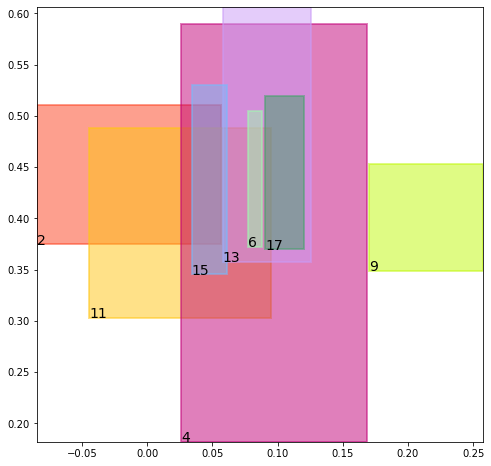

neg alignment data:
tensor(4) 0.02584262192249298 0.1820831596851349 tensor(0.1686311066150665) tensor(0.5893871188163757)
tensor(14) 0.05204976350069046 0.292916476726532 tensor(0.1373203396797180) tensor(0.5618486404418945)
tensor(6) 0.07726072520017624 0.3719407320022583 tensor(0.0880022421479225) tensor(0.5043252110481262)
tensor(16) 0.11007224768400192 0.40974968671798706 tensor(0.1505877077579498) tensor(0.5162158608436584)
tensor(5) 0.11304252594709396 0.3871040344238281 tensor(0.1142951771616936) tensor(0.6324584484100342)
tensor(15) 0.03400997817516327 0.3452932834625244 tensor(0.0610499456524849) tensor(0.5296712517738342)
tensor(11) -0.044454626739025116 0.3028077185153961 tensor(0.0951082035899162) tensor(0.4884748458862305)


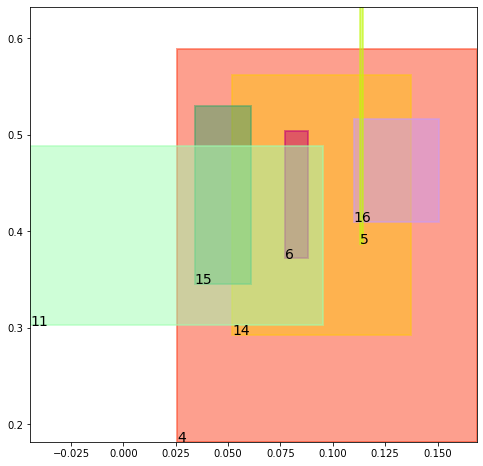

key mouse_cond_kl_loss
val tensor(3.8889667987823486, grad_fn=<MeanBackward0>)
key human_cond_kl_loss
val tensor(3.9282388687133789, grad_fn=<MeanBackward0>)
key align_cond_kl_loss
val tensor(0.0341669768095016, grad_fn=<MulBackward0>)
A_given_B: tensor([[ 2, 11],
        [ 4, 13],
        [ 9, 17]]) tensor([0., 0., 0.])
B_given_A: tensor([[11,  2],
        [13,  4],
        [17,  9]]) tensor([0., 0., 0.])
align_evaluation_train_align_0.5_metric_hard_accuracy_align tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align tensor(nan)
align_evaluation_train_align_0.5_metric_hard_accuracy_align_mean tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align_mean tensor(nan)
A_given_B: tensor([[ 6, 15],
        [ 6, 16],
        [ 5, 15],
        [ 4, 15],
        [ 6, 11]]) tensor([0., 0., 0., 0., 0.])
B_given_A: tensor([[15,  6],
        [16,  6],
        [15,  5],
        [15,  4],
        [11,  6]]) tensor([5.3931493736776370e-40, 4.2038953929744512e-45, 0.000000000000000

key mouse_cond_kl_loss
val tensor(3.7201948165893555, grad_fn=<MeanBackward0>)
key human_cond_kl_loss
val tensor(3.7618417739868164, grad_fn=<MeanBackward0>)
key align_cond_kl_loss
val tensor(0.0802892372012138, grad_fn=<MulBackward0>)
A_given_B: tensor([[ 2, 11],
        [ 4, 13],
        [ 9, 17]]) tensor([0.0000000000000000e+00, 1.6341052949428558e-02, 2.5223372357846707e-44])
B_given_A: tensor([[11,  2],
        [13,  4],
        [17,  9]]) tensor([9.4039449468255043e-03, 2.2442845880010189e-39, 0.0000000000000000e+00])
align_evaluation_train_align_0.5_metric_hard_accuracy_align tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align tensor(nan)
align_evaluation_train_align_0.5_metric_hard_accuracy_align_mean tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align_mean tensor(nan)
A_given_B: tensor([[ 6, 15],
        [ 6, 16],
        [ 5, 15],
        [ 4, 15],
        [ 6, 11]]) tensor([2.6602782540158771e-39, 3.7889762426220373e-38, 0.0000000000000000e+00,
    

key mouse_cond_kl_loss
val tensor(3.5522210597991943, grad_fn=<MeanBackward0>)
key human_cond_kl_loss
val tensor(3.6023862361907959, grad_fn=<MeanBackward0>)
key align_cond_kl_loss
val tensor(0.0841033831238747, grad_fn=<MulBackward0>)
A_given_B: tensor([[ 2, 11],
        [ 4, 13],
        [ 9, 17]]) tensor([0.0000000000000000e+00, 0.0000000000000000e+00, 3.7170702934833665e-40])
B_given_A: tensor([[11,  2],
        [13,  4],
        [17,  9]]) tensor([0.0000000000000000e+00, 8.8342059086429443e-41, 0.0000000000000000e+00])
align_evaluation_train_align_0.5_metric_hard_accuracy_align tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align tensor(nan)
align_evaluation_train_align_0.5_metric_hard_accuracy_align_mean tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align_mean tensor(nan)
A_given_B: tensor([[ 6, 15],
        [ 6, 16],
        [ 5, 15],
        [ 4, 15],
        [ 6, 11]]) tensor([0.0000000000000000e+00, 0.0000000000000000e+00, 1.9478048654114957e-43,
    

key mouse_cond_kl_loss
val tensor(3.3892474174499512, grad_fn=<MeanBackward0>)
key human_cond_kl_loss
val tensor(3.4502000808715820, grad_fn=<MeanBackward0>)
key align_cond_kl_loss
val tensor(0.0463868863880634, grad_fn=<MulBackward0>)
A_given_B: tensor([[ 2, 11],
        [ 4, 13],
        [ 9, 17]]) tensor([9.4645187258720398e-02, 4.1599228978157043e-02, 8.6301952251233160e-05])
B_given_A: tensor([[11,  2],
        [13,  4],
        [17,  9]]) tensor([0.0000000000000000e+00, 7.8631257638335228e-03, 1.9728530754613018e-39])
align_evaluation_train_align_0.5_metric_hard_accuracy_align tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align tensor(nan)
align_evaluation_train_align_0.5_metric_hard_accuracy_align_mean tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align_mean tensor(nan)
A_given_B: tensor([[ 6, 15],
        [ 6, 16],
        [ 5, 15],
        [ 4, 15],
        [ 6, 11]]) tensor([1.9937187433242798e-02, 2.0886752980823731e-38, 3.4807638371603389e-07,
    

key mouse_cond_kl_loss
val tensor(3.2326579093933105, grad_fn=<MeanBackward0>)
key human_cond_kl_loss
val tensor(3.3046212196350098, grad_fn=<MeanBackward0>)
key align_cond_kl_loss
val tensor(0.0352905541658401, grad_fn=<MulBackward0>)
A_given_B: tensor([[ 2, 11],
        [ 4, 13],
        [ 9, 17]]) tensor([0.2376116663217545, 0.1923360973596573, 0.0006965094362386])
B_given_A: tensor([[11,  2],
        [13,  4],
        [17,  9]]) tensor([0.0067644217051566, 0.0845370143651962, 0.0290204118937254])
align_evaluation_train_align_0.5_metric_hard_accuracy_align tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align tensor(nan)
align_evaluation_train_align_0.5_metric_hard_accuracy_align_mean tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align_mean tensor(nan)
A_given_B: tensor([[ 6, 15],
        [ 6, 16],
        [ 5, 15],
        [ 4, 15],
        [ 6, 11]]) tensor([1.0769021511077881e-01, 7.2045505046844482e-01, 5.9650706134561915e-06,
        1.1279973387718201e-

key mouse_cond_kl_loss
val tensor(3.0842692852020264, grad_fn=<MeanBackward0>)
key human_cond_kl_loss
val tensor(3.1638472080230713, grad_fn=<MeanBackward0>)
key align_cond_kl_loss
val tensor(0.0334345661103725, grad_fn=<MulBackward0>)
A_given_B: tensor([[ 2, 11],
        [ 4, 13],
        [ 9, 17]]) tensor([0.5388651490211487, 0.4498935937881470, 0.0082421908155084])
B_given_A: tensor([[11,  2],
        [13,  4],
        [17,  9]]) tensor([0.1238896995782852, 0.3105658888816833, 0.0785723775625229])
align_evaluation_train_align_0.5_metric_hard_accuracy_align tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align tensor(nan)
align_evaluation_train_align_0.5_metric_hard_accuracy_align_mean tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align_mean tensor(nan)
A_given_B: tensor([[ 6, 15],
        [ 6, 16],
        [ 5, 15],
        [ 4, 15],
        [ 6, 11]]) tensor([1.0580972582101822e-01, 8.8603538274765015e-01, 8.3327558968449011e-06,
        2.7513194084167480e-

key mouse_cond_kl_loss
val tensor(2.9389517307281494, grad_fn=<MeanBackward0>)
key human_cond_kl_loss
val tensor(3.0303733348846436, grad_fn=<MeanBackward0>)
key align_cond_kl_loss
val tensor(0.0249962378293276, grad_fn=<MulBackward0>)
A_given_B: tensor([[ 2, 11],
        [ 4, 13],
        [ 9, 17]]) tensor([0.2653443217277527, 0.5245402455329895, 0.0578488782048225])
B_given_A: tensor([[11,  2],
        [13,  4],
        [17,  9]]) tensor([0.4000467061996460, 0.3856983780860901, 0.2399608492851257])
align_evaluation_train_align_0.5_metric_hard_accuracy_align tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align tensor(nan)
align_evaluation_train_align_0.5_metric_hard_accuracy_align_mean tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align_mean tensor(nan)
A_given_B: tensor([[ 6, 15],
        [ 6, 16],
        [ 5, 15],
        [ 4, 15],
        [ 6, 11]]) tensor([9.7126469016075134e-02, 8.3473479747772217e-01, 5.9569638324319385e-06,
        4.1547450423240662e-

key mouse_cond_kl_loss
val tensor(2.7995624542236328, grad_fn=<MeanBackward0>)
key human_cond_kl_loss
val tensor(2.9018614292144775, grad_fn=<MeanBackward0>)
key align_cond_kl_loss
val tensor(0.0186810325831175, grad_fn=<MulBackward0>)
A_given_B: tensor([[ 2, 11],
        [ 4, 13],
        [ 9, 17]]) tensor([0.3351887464523315, 0.6540845632553101, 0.0496927648782730])
B_given_A: tensor([[11,  2],
        [13,  4],
        [17,  9]]) tensor([0.5031021237373352, 0.4147555828094482, 0.1384263336658478])
align_evaluation_train_align_0.5_metric_hard_accuracy_align tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align tensor(nan)
align_evaluation_train_align_0.5_metric_hard_accuracy_align_mean tensor(0.3333333432674408)
align_evaluation_train_align_0.5_metric_hard_f1_align_mean tensor(0.5000000000000000)
A_given_B: tensor([[ 6, 15],
        [ 6, 16],
        [ 5, 15],
        [ 4, 15],
        [ 6, 11]]) tensor([9.6202403306961060e-02, 7.3408830165863037e-01, 1.9632409475889290e-0

key mouse_cond_kl_loss
val tensor(2.6646471023559570, grad_fn=<MeanBackward0>)
key human_cond_kl_loss
val tensor(2.7762818336486816, grad_fn=<MeanBackward0>)
key align_cond_kl_loss
val tensor(0.0173677839338779, grad_fn=<MulBackward0>)
A_given_B: tensor([[ 2, 11],
        [ 4, 13],
        [ 9, 17]]) tensor([0.3807071149349213, 0.6020470857620239, 0.0572001710534096])
B_given_A: tensor([[11,  2],
        [13,  4],
        [17,  9]]) tensor([0.5830835103988647, 0.4872848689556122, 0.0708219110965729])
align_evaluation_train_align_0.5_metric_hard_accuracy_align tensor(0.)
align_evaluation_train_align_0.5_metric_hard_f1_align tensor(nan)
align_evaluation_train_align_0.5_metric_hard_accuracy_align_mean tensor(0.3333333432674408)
align_evaluation_train_align_0.5_metric_hard_f1_align_mean tensor(0.5000000000000000)
A_given_B: tensor([[ 6, 15],
        [ 6, 16],
        [ 5, 15],
        [ 4, 15],
        [ 6, 11]]) tensor([9.7194850444793701e-02, 5.9354698657989502e-01, 1.8507339518691879e-0

key mouse_cond_kl_loss
val tensor(2.5379054546356201, grad_fn=<MeanBackward0>)
key human_cond_kl_loss
val tensor(2.6552693843841553, grad_fn=<MeanBackward0>)
key align_cond_kl_loss
val tensor(0.0154118137434125, grad_fn=<MulBackward0>)
A_given_B: tensor([[ 2, 11],
        [ 4, 13],
        [ 9, 17]]) tensor([0.3611454367637634, 0.6615246534347534, 0.3944798409938812])
B_given_A: tensor([[11,  2],
        [13,  4],
        [17,  9]]) tensor([6.2440097332000732e-01, 5.8444190025329590e-01, 2.0779941807977500e-38])
align_evaluation_train_align_0.5_metric_hard_accuracy_align tensor(0.3333333432674408)
align_evaluation_train_align_0.5_metric_hard_f1_align tensor(0.5000000000000000)
align_evaluation_train_align_0.5_metric_hard_accuracy_align_mean tensor(0.3333333432674408)
align_evaluation_train_align_0.5_metric_hard_f1_align_mean tensor(0.5000000000000000)
A_given_B: tensor([[ 6, 15],
        [ 6, 16],
        [ 5, 15],
        [ 4, 15],
        [ 6, 11]]) tensor([8.5238732397556305e-02, 3.

In [23]:
nEpochs = 1000
l.train(nEpochs)